In [1]:
import json, os, nltk, sys
sys.path.append("../")
from process_dataset import process_dataset
from collections import Counter
from tqdm import tqdm

/home/lamdo/miniconda3/envs/venv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
KG_RESULTS_FOLDER = "/scratch/lamdo/precompute_keyphrase_extraction"

datasets = ["scifact_queries", "scidocs_queries", "trec_covid_queries", "nfcorpus_queries", "doris_mae_queries", "acm_cr_queries"]
# datasets = ["scifact", "scidocs", "trec_covid", "nf_corpus", "doris_mae", "acm_cr"]
models = ["autokeygen-1", "copyrnn-1", "uokg-1", "retrieval_based_ukg_custom_trained_combined_references_nounphrase_v8-1_position_penalty+length_penalty", "tpg-1"][:]

In [6]:
PORTER_STEMMER = nltk.stem.PorterStemmer()
def check_absent_keyphrase_type(text, absent_keyphrases):
    # 0: reordered, 1: mix, 2: unseen

    text_tokens = nltk.tokenize.word_tokenize(text.lower())
    stemmed_text_tokens = set([PORTER_STEMMER.stem(token) for token in text_tokens])
    stemmed_text_tokens_joined = " ".join(stemmed_text_tokens)

    absent_keyphrases_types = []
    absent_terms_added = set([])
    terms_added = set([])
    for absent_keyphrase in absent_keyphrases:
        absent_keyphrase_tokens = nltk.tokenize.word_tokenize(absent_keyphrase)
        stemmed_absent_keyphrase_tokens = set([PORTER_STEMMER.stem(token) for token in absent_keyphrase_tokens])

        overlap_keyphrase_text = set([tok for tok in stemmed_absent_keyphrase_tokens if tok in stemmed_text_tokens_joined])
        absent_terms = stemmed_absent_keyphrase_tokens.difference(overlap_keyphrase_text)
        absent_terms_added.update(absent_terms)
        terms_added.update(stemmed_absent_keyphrase_tokens)

        if len(overlap_keyphrase_text) == len(absent_keyphrase_tokens): 
            absent_keyphrases_types.append(0)
        elif len(absent_keyphrase_tokens) > len(overlap_keyphrase_text) > 0: 
            absent_keyphrases_types.append(1)
        else: 
            absent_keyphrases_types.append(2)

    return absent_keyphrases_types, len(absent_terms_added), len(terms_added)

In [8]:
record = {}
number_of_absent_terms_added = {}
total = {}
number_of_inputs = 0
for dataset in datasets[:]:
    record[dataset] = {}
    ds = process_dataset(dataset)
    number_of_inputs += len(ds)
    for model in models:
        record[dataset][model] = Counter()

        if not number_of_absent_terms_added.get(model):
            number_of_absent_terms_added[model] = 0
            total[model] = 0

        file_name = f"{dataset}--{model}.json"
        file_path = os.path.join(KG_RESULTS_FOLDER, file_name)

        with open(file_path, "r") as f:
            data = json.load(f)

        top_k = 5 if "queries" in dataset else 10
        all_absent_keyphrases = [item["automatically_extracted_keyphrases"]["present_keyphrases"][:top_k] + item["automatically_extracted_keyphrases"]["absent_keyphrases"][:top_k] for item in data]
        
        assert len(ds) == len(all_absent_keyphrases)
        for i in tqdm(range(len(ds)), desc=f"{dataset}--{model}"):
            line = ds[i]
            absent_keyphrases = all_absent_keyphrases[i]

            temp = list(check_absent_keyphrase_type(line["text"], absent_keyphrases))
            absent_keyphrase_type = temp[0]
            num_absent_terms_added = temp[1]
            num_terms = temp[2]

            number_of_absent_terms_added[model] += num_absent_terms_added
            total[model] += num_terms

            record[dataset][model].update(Counter(absent_keyphrase_type))


# with open("absent_keyphrase_distribution_result.json", "w") as f:
#     json.dump(record, f, indent = 4)

scifact_queries--uokg-1: 100%|██████████| 1109/1109 [00:01<00:00, 705.71it/s]
scifact_queries--retrieval_based_ukg_custom_trained_combined_references_nounphrase_v8-1_position_penalty+length_penalty: 100%|██████████| 1109/1109 [00:01<00:00, 779.49it/s]
scidocs_queries--uokg-1: 100%|██████████| 1000/1000 [00:01<00:00, 633.95it/s]
scidocs_queries--retrieval_based_ukg_custom_trained_combined_references_nounphrase_v8-1_position_penalty+length_penalty: 100%|██████████| 1000/1000 [00:01<00:00, 676.21it/s]
trec_covid_queries--uokg-1: 100%|██████████| 50/50 [00:00<00:00, 733.87it/s]
trec_covid_queries--retrieval_based_ukg_custom_trained_combined_references_nounphrase_v8-1_position_penalty+length_penalty: 100%|██████████| 50/50 [00:00<00:00, 845.55it/s]
nfcorpus_queries--uokg-1: 100%|██████████| 3237/3237 [00:03<00:00, 1066.16it/s]
nfcorpus_queries--retrieval_based_ukg_custom_trained_combined_references_nounphrase_v8-1_position_penalty+length_penalty: 100%|██████████| 3237/3237 [00:02<00:00, 114

In [9]:
number_of_absent_terms_added, total, {k:round(v / number_of_inputs,1) for k,v in number_of_absent_terms_added.items()}, number_of_inputs

({'autokeygen-1': 13924,
  'copyrnn-1': 56285,
  'uokg-1': 10101,
  'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v8-1_position_penalty+length_penalty': 26524,
  'tpg-1': 25180},
 {'autokeygen-1': 41135,
  'copyrnn-1': 81679,
  'uokg-1': 35950,
  'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v8-1_position_penalty+length_penalty': 55874,
  'tpg-1': 47133},
 {'autokeygen-1': 2.3,
  'copyrnn-1': 9.3,
  'uokg-1': 1.7,
  'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v8-1_position_penalty+length_penalty': 4.4,
  'tpg-1': 4.2},
 6048)

In [58]:
{k:100 * round(number_of_absent_terms_added[k]/total[k], 3) for k in number_of_absent_terms_added}

{'autokeygen-1': 33.5,
 'copyrnn-1': 60.9,
 'uokg-1': 12.6,
 'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v6-1_position_penalty+length_penalty': 51.1,
 'tpg-1': 50.9}

In [10]:
record

{'semeval': {'autokeygen-1': Counter({0: 944, 1: 56}),
  'copyrnn-1': Counter({0: 707, 1: 270, 2: 23}),
  'uokg-1': Counter({0: 628, 1: 361, 2: 11}),
  'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v6-1_position_penalty+length_penalty': Counter({1: 650,
           0: 229,
           2: 121}),
  'tpg-2': Counter({1: 464, 2: 377, 0: 159})},
 'inspec': {'autokeygen-1': Counter({0: 4605, 1: 394, 2: 1}),
  'copyrnn-1': Counter({0: 3521, 1: 1291, 2: 188}),
  'uokg-1': Counter({0: 3208, 1: 1746, 2: 46}),
  'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v6-1_position_penalty+length_penalty': Counter({1: 3024,
           0: 996,
           2: 980}),
  'tpg-2': Counter({2: 2271, 1: 2023, 0: 673})},
 'krapivin': {'autokeygen-1': Counter({0: 4251, 1: 348, 2: 1}),
  'copyrnn-1': Counter({0: 3388, 1: 1137, 2: 75}),
  'uokg-1': Counter({0: 2818, 1: 1726, 2: 56}),
  'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v6-1_position_penalty+length_

# Draw histogram for presentation

In [16]:
with open("absent_keyphrase_distribution_result.json", "r") as f:
    record = json.load(f)

In [17]:
def draw_histogram(data):
    import matplotlib.pyplot as plt
    import numpy as np

    model_name_mapper = {
        "autokeygen-1": "AutoKeyGen",
        "copyrnn-1": "CopyRNN",
        "uokg-1": "UOKG",
        "retrieval_based_ukg_custom_trained_combined_references_nounphrase_v6-1_position_penalty+length_penalty": "ERU-KG",
        "tpg-2": "TPG"
    }

    # Prepare data for the histogram
    x_labels = ["reordered", "mixed", "unseen"]
    values = {key: [data[key].get(str(x), 0) for x in range(3)] for key in data}

    # Draw the histogram
    x = np.arange(len(x_labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each dataset
    for i, (key, value) in enumerate(values.items()):
        ax.bar(x + i * width, value, width, label=model_name_mapper[key])

    # Add labels, title, and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Proportions')
    ax.set_title('Distribution of absent keyphrases')
    ax.set_xticks(x + width * (len(values) - 1) / 2)
    ax.set_xticklabels(x_labels)
    ax.legend()

    # plt.show()
    plt.savefig('absent_keyphrase_distribution.pdf')

In [18]:
# normalize data

normalized_record = {}
for dataset in record:
    normalized_record[dataset] = {}

    for model in record[dataset]:
        normalized_record[dataset][model] = {}

        total = sum(record[dataset][model].values())
        for key in record[dataset][model]:
            normalized_record[dataset][model][key] = record[dataset][model][key] / total


aggregated_normalized_record = {}

for dataset in normalized_record:

    for model in normalized_record[dataset]:
        if model not in aggregated_normalized_record:
            aggregated_normalized_record[model] = {}

        for key in normalized_record[dataset][model]:
            if key not in aggregated_normalized_record[model]:
                aggregated_normalized_record[model][key] = normalized_record[dataset][model][key] / len(normalized_record)
            else:
                aggregated_normalized_record[model][key] += normalized_record[dataset][model][key]/ len(normalized_record)

In [19]:
normalized_record

{'semeval': {'autokeygen-1': {'0': 0.944, '1': 0.056},
  'copyrnn-1': {'0': 0.707, '1': 0.27, '2': 0.023},
  'uokg-1': {'1': 0.361, '0': 0.628, '2': 0.011},
  'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v6-1_position_penalty+length_penalty': {'0': 0.229,
   '1': 0.65,
   '2': 0.121},
  'tpg-2': {'0': 0.159, '2': 0.377, '1': 0.464}},
 'inspec': {'autokeygen-1': {'0': 0.921, '1': 0.0788, '2': 0.0002},
  'copyrnn-1': {'0': 0.7042, '2': 0.0376, '1': 0.2582},
  'uokg-1': {'0': 0.6416, '1': 0.3492, '2': 0.0092},
  'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v6-1_position_penalty+length_penalty': {'0': 0.1992,
   '2': 0.196,
   '1': 0.6048},
  'tpg-2': {'1': 0.4072881014697,
   '2': 0.4572176364002416,
   '0': 0.13549426213005838}},
 'krapivin': {'autokeygen-1': {'0': 0.9241304347826087,
   '1': 0.07565217391304348,
   '2': 0.0002173913043478261},
  'copyrnn-1': {'1': 0.24717391304347827,
   '0': 0.7365217391304347,
   '2': 0.016304347826086956},


In [20]:
aggregated_normalized_record

{'autokeygen-1': {'0': 0.929628066299967,
  '1': 0.0701823864943493,
  '2': 0.00018954720568369442},
 'copyrnn-1': {'0': 0.7254963943814665,
  '1': 0.24933904490051237,
  '2': 0.025164560718021218},
 'uokg-1': {'1': 0.36764759137989456,
  '0': 0.622431585136974,
  '2': 0.009920823483131334},
 'retrieval_based_ukg_custom_trained_combined_references_nounphrase_v6-1_position_penalty+length_penalty': {'0': 0.21630761570376195,
  '1': 0.6153992461735199,
  '2': 0.16829313812271815},
 'tpg-2': {'0': 0.16294394403448062,
  '2': 0.3961146717769918,
  '1': 0.4409413841885276}}

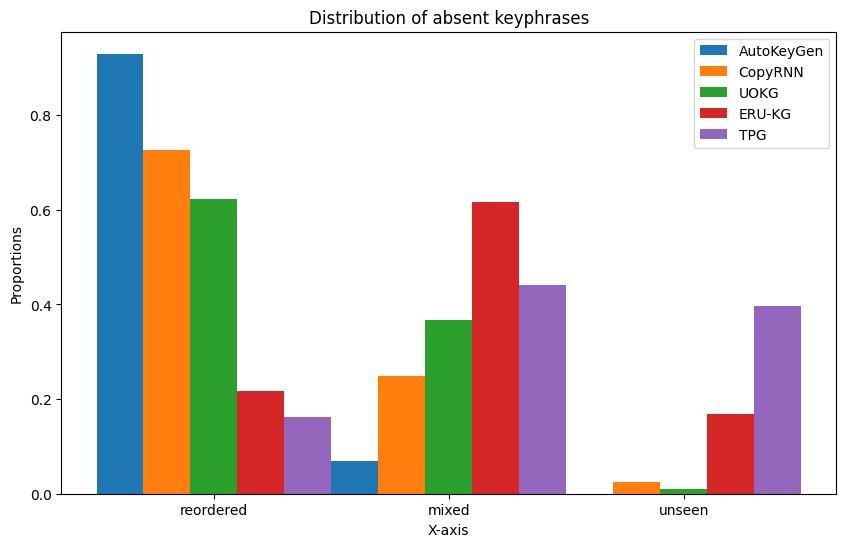

In [21]:
draw_histogram(aggregated_normalized_record)